# UBC-MDS/DSCI_522_group_401
# Predicting Medical Insurance Cost
Authors: Karanpal Singh, Sreejith Munthikodu, Sirine Chahma  
[Data Source](https://gist.github.com/meperezcuello/82a9f1c1c473d6585e750ad2e3c05a41)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from sklearn.model_selection import train_test_split

### Load the data

In [2]:
medical_data = pd.read_csv("../data/original/medical_cost_data.csv")
medical_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
print(f"Total number of samples: {medical_data.shape[0]}")

Total number of samples: 1338


### Split the data into training and test

In [4]:
X = medical_data.drop(columns="charges")
y = medical_data.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

### Save the training and test data

In [5]:
# Combine X and y
medical_cost_data_training = pd.concat([X_train, y_train], axis=1)
medical_cost_data_test = pd.concat([X_test, y_test], axis=1)

medical_cost_data_training.to_csv("../data/processed/medical_cost_data_training.csv", index=False )
medical_cost_data_test.to_csv("../data/processed/medical_cost_data_test.csv", index=False)

# Resetting variables to zero to prevent any data leakage
X_train, X_test, y_train, y_test = 0, 0, 0, 0

# Exploratory Data Analysis
### Hereafter only the training data is used. 

In [6]:
# load training data
medical_data = pd.read_csv("../data/processed/medical_cost_data_training.csv") 

X_train = medical_data.drop(columns="charges")
y_train = medical_data.charges

### Basic preprocessing

In [7]:
X_train.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
dtype: object

In [8]:
# Check for missing values
X_train.isna().any().any()

False

There are no missing values in our data

In [9]:
# Identify categoric and numeric features
data_types = X_train.dtypes
categoric_features = []
numeric_features = []
for d_type, feature in zip(data_types, data_types.index):
    if d_type == "object":
        categoric_features.append(feature)
    else:
        numeric_features.append(feature)

numeric_features = numeric_features
print(f"Numeric features are: {numeric_features}")
print(f"Categoric features are: {categoric_features}")

Numeric features are: ['age', 'bmi', 'children']
Categoric features are: ['sex', 'smoker', 'region']


In [10]:
# Explore cardinality in categoric features
print(f"Total samples: {X_train.shape[0]}")
for cat_feature in categoric_features:
    print(f"Number of unique values in {cat_feature} is {X_train[cat_feature].nunique()}")

Total samples: 936
Number of unique values in sex is 2
Number of unique values in smoker is 2
Number of unique values in region is 4


In [11]:
# Detect outliers in numeric features

def detect_outlier(x):
    """
    Detect outliers from the given array using inter-quartile range. 
    Considered an outlier if value is less than Q1 - 1.5 IQR or
    Q2 + 1.5 IQR
    
    Parameters
    ----------
    x : list, array-like
        input array of numbers

    Returns
    -------
    tuple
        tuple containing indices of the outliers and outliers 

    """
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    ceil =  Q3 + 1.5*IQR
    floor = Q1 - 1.5*IQR
    outlier_index = x.index[(x < floor) | (x > ceil)]
    outliers = x[outlier_index]
    
    return outlier_index, outliers

outliers = {}
for col in numeric_features:
    outlier_index, outliers = detect_outlier(X_train[col])
    outliers[col] = outlier_index
    print(f"Total outliers in {col} is {len(outliers)}")
    

Total outliers in age is 1
Total outliers in bmi is 9
Total outliers in children is 1


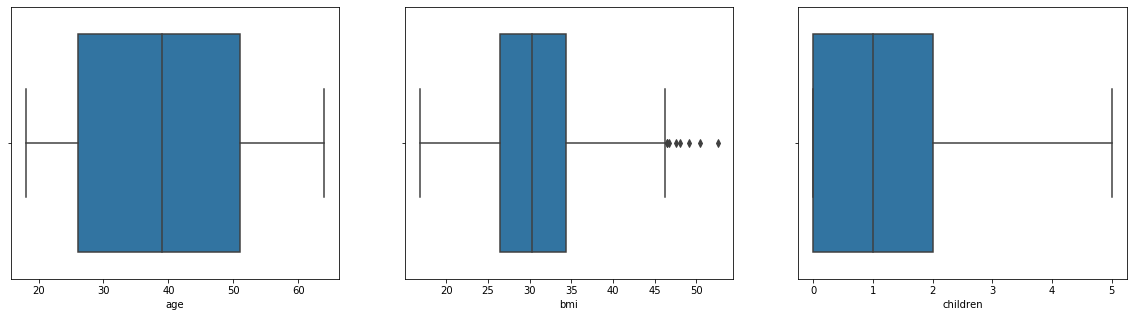

In [12]:
# Visualize the distribution using boxplot
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
axes = ax.reshape(-1)
for col, ax in zip(numeric_features, axes):
    sns.boxplot(col,  data = X_train, ax = ax)

In [16]:
X_train.describe()

,age,bmi,children
count,936.000000,936.000000,936.000000
mean,39.106838,30.628542,1.073718
std,14.092108,5.909664,1.221866
min,18.000000,16.815000,0.000000
25%,26.000000,26.410000,0.000000
50%,39.000000,30.275000,1.000000
75%,51.000000,34.430000,2.000000
max,64.000000,52.580000,5.000000


When we look at the scope of the numerical features, we realize that all the values belong to a plausible range. Even though our previous analysis reveled some extreme values, we are going to keep those values because they corresponds to a rare situation that could occur, they are not related to an error in the measurement.

### Exploring features

**Let's see if medical expenses tend to change with the age of a person**

In [ ]:
training_df = X_train
training_df['charges'] = y_train


alt.Chart(training_df.groupby(['age']).mean().reset_index()).mark_line(point = True).encode(
    alt.X('age:N', title = 'Age'),
    alt.Y('charges:Q', title = 'Charges')
).properties(title='Charges VS age')

The charges seem to increase when the age of a person increases. There is a peak in the expenses at the age of 43.

**Let's see if medical expenses tend to change with the BMI of a person**

In [ ]:
training_df = X_train
training_df['charges'] = y_train


alt.Chart(training_df.groupby(['bmi']).mean().reset_index()).mark_area().encode(
    alt.X('bmi:Q', title = 'BMI', bin=alt.Bin(maxbins=60)),
    alt.Y('charges:Q', title = 'Charges')
).properties(title='Charges VS BMI')

The highest expenses seem to occur for people who have a BMI that is higher than 34. 

**Let's see how much money males and females spending for medical treatments during their lifetime**

In [ ]:
training_df = X_train
training_df['charges'] = y_train


alt.Chart(training_df.groupby(['age','sex']).mean().reset_index()).mark_line(point = True).encode(
    alt.X('age:N', title = 'Age'),
    alt.Y('charges:Q', title = 'Charges'),
    alt.Color('sex:N')
).properties(title='Charges VS age for each sex')

The expenses seem to grow with age for both males and females. There is a peak in the male charges around the age of 60. The increase we noticed before that occurs at the age of 43 happens to both genders. 

**Let's see how smokers and non smokers are spending for medical treatments during their lifetime**

We expect expenditures by smokers should be higher than the non smokers.

In [ ]:
alt.Chart(training_df.groupby(['age','smoker']).mean().reset_index()).mark_line(point = True).encode(
    alt.X('age:N', title = 'Age'),
    alt.Y('charges:Q', title = 'Charges'),
    alt.Color('smoker:N')
).properties(title='Charges VS age for smokers and non-smokers')

Health expenses of smokers are a lot higher than the one of non-smokers. 

**Let's see how BMI is changing with Age for Males and Females**

We are expecting both male and females have usual BMI.

In [ ]:
alt.Chart(X_train).mark_point().encode(
    
    alt.X('age:N', title = 'Age'),
    alt.Y('bmi:Q', title = 'BMI'),
    alt.Color('sex:N')
).properties(title='BMI vs Age for each sex')

The BMI doesn't seem to vary depending on the age nor the sex.

**Let's see how the spending for medical treatments changes regarding to the BMI of a person**

We expect expenditures to be higher for people who have very high BMI.

In [ ]:
training_df = X_train
training_df['charges'] = y_train


alt.Chart(training_df.groupby(['bmi','sex']).mean().reset_index()).mark_area().encode(
    alt.X('bmi:Q', title = 'BMI', bin=alt.Bin(maxbins=60)),
    alt.Y('charges:Q', title = 'Charges'),
    alt.Color('sex:N')
).properties(title='Charges VS BMI for each sex')

The highest expenses seem to occur for people from both genders who have a BMI that is higher than 34. 